# Tutorial de Deep Learning -- Pytorch

## Carregamento dos dados

In [37]:
## Importar as bibliotecas para carregar os dados com o pytorch
import torch
import os
import numpy as np
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt

### Base MNIST

**Carregar as imagens da MNist e normalizar**

In [30]:
#Aplicar a normalização na imagem
tf_image = transforms.Compose([transforms.ToTensor(),
                               transforms.Lambda(lambda x: x.repeat(3, 1, 1)), 
                               transforms.Normalize((0.5,), (0.5,))])
#importar a mnist
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=tf_image)
test_datset = datasets.MNIST(root='./data', train=False, download=True, transform=tf_image)

**Consultar o número de exemplos**

In [31]:
print(f"num exemplos no treino: {len(train_dataset)}")
print(f"num exemplos no teste: {len(test_datset)}")

num exemplos no treino: 60000
num exemplos no teste: 10000


**Mostrar alguns exemplos de imagens**

Epoch 0: 100%|██████████| 1875/1875 [36:59<00:00,  1.18s/it, v_num=7, loss=2.350, acc=0.113, f1_score=0.020] 


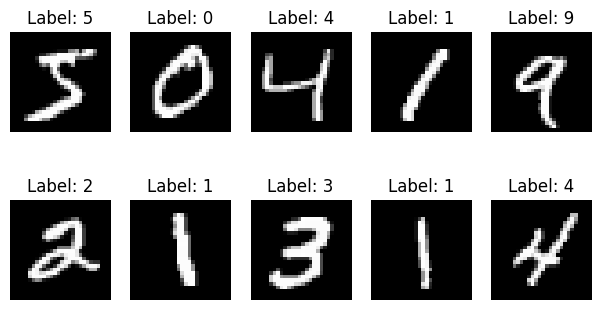

In [34]:
#Mostrar as imagens
num_row = 2
num_col = 5

plt.figure(figsize=(1.5*num_col,2*num_row))
for i in range(10):
    image, label = train_dataset[i]
    plt.subplot(num_row,num_col,i+1)
    plt.imshow(image[0].reshape(28,28), cmap='gray')
    plt.title('Label: {}'.format(label))
    plt.axis("off")
plt.show()

Transformar dados em um dataloader

In [35]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, num_workers=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_datset, batch_size=32, num_workers=8, shuffle=False)

### Base de imagens de CT-Scan

**Criar o custom dataset**

In [38]:
from torchvision.datasets import ImageFolder

In [46]:
class CTDataset(torch.utils.data.Dataset):
    '''
        classe para importar imagens de uma classe especifica
        fonte: https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images
        params:
            - path: caminho para o repositório de imagens
            - tf_image: normaliza a imagem
    '''
    def __init__(self, path, tf_image, train=True, test=False, val=False):
        
        #selecionar a partição de dados que será coletada da pasta
        if test:
            self.data = ImageFolder(root=os.path.join(path, 'test'), transform=tf_image)
        elif val:
            self.data = ImageFolder(root=os.path.join(path, 'valid'), transform=tf_image)
        else:
            self.data = ImageFolder(root=os.path.join(path, 'train'), transform=tf_image)
        
        # self.X = []
        # self.y = []
        
        # self.X, self.y = zip(*[(x, y) for x, y in self.dataset])
        
        # self.X = torch.stack(list(self.X))
        # self.y = torch.tensor(list(self.y))
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = self.data[idx][0]
        y = self.data[idx][1]
        
        return x, y

In [47]:
tf_image = transforms.Compose([ transforms.Resize((224, 224)),
                                transforms.ToTensor(),  
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [48]:
train_data_ct = CTDataset(path="./data/CT/", tf_image=tf_image, train=True)
test_data_ct = CTDataset(path="./data/CT/", tf_image=tf_image, train=False, test=True)

In [50]:
train_loader_ct = torch.utils.data.DataLoader(train_data_ct, batch_size=32, num_workers=8, shuffle=True)
test_loader_ct = torch.utils.data.DataLoader(test_data_ct, batch_size=32, num_workers=8, shuffle=False)

## Construir o modelo

**Modelo customizado**

In [17]:
class MyNet(torch.nn.Module):
    #Inicialização da rede
    def __init__(self):
        super(MyNet, self).__init__()
        #A camada convolucional de entrada recebe a image de input e tem como saíde 10 canais
        9# n_out = [(input_size + 2*padding - kernel)/stride]+ 1
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        # A conv 2 tem como entrada os 16 canais da anteriror
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Dropout(p=0.5),
        )
        #camadas conectadas
        self.fc1 = torch.nn.Linear(32*7*7, 50)
        #A ultima camada contém o numero de classes
        self.fc2 = torch.nn.Linear(50, 10)
        self.activation = torch.nn.Softmax(dim=1)
    
    def forward(self, x):
        #add a conv 1
        x = self.conv1(x)
        #add a conv 2
        x= self.conv2(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.activation(x)
        
        return x

**Modelo a partir da ResNet50**

In [24]:
#Importar as arquiteura limpa
from torchvision.models import resnet50
from torchvision.models.resnet import ResNet50_Weights

In [28]:
#criação e modificação do modelo
# Definição do modelo base pre-treinado na ImageNet
model_resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

#Alteração das camadas para adicionar a camada que representa o número de classes
model_resnet.fc = torch.nn.Sequential(
    torch.nn.Linear(model_resnet.fc.in_features, 10),
    torch.nn.Softmax(dim=1)
)

**Inicializando a rede**

In [18]:
network = MyNet()

## Treinamento do Modelo

**importar as bibliotecas de treinamento o pytorch lightning**

In [8]:
import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger
from torchmetrics import Accuracy, F1Score


/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


### Classe para o treinamento do modelo com o pytorch

In [19]:
class TrainTestModel(L.LightningModule):
    '''
        Classe para configuração do treinamento do modelo
        params:
            - model: model base para o treinamento
            - lr: taxa de aprendizado
    '''
    def __init__(self, model, lr):
        super().__init__()
        self.model = model
        self.lr = lr
        
        #definindo a função de perda
        self.loss = torch.nn.CrossEntropyLoss()
        
        #configuração das metricas
        self.train_acc = Accuracy(task='multiclass', num_classes=10)
        self.test_acc = Accuracy(task='multiclass', num_classes=10)
        
        self.train_f1 = F1Score(task="multiclass", num_classes=10, average="macro")
        self.test_f1 = F1Score(task="multiclass", num_classes=10, average="macro")
        

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        #coleta os labels e imagens o batch
        x, y = batch
        
        #resultado da saida da rede, que é a softmax
        outputs = self.forward(x)
        
        #calculando a perda
        y_true = y.squeeze()
        loss_value = self.loss(outputs, y_true)
        
        #coletando os labels preditos
        y_pred = torch.argmax(outputs, dim=1)
        
        acc = self.train_acc(y_pred, y_true)
        f1 = self.train_f1(y_pred, y_true)
        
        self.log('loss', loss_value.item(), prog_bar=True)
        self.log('acc', acc, prog_bar=True)
        self.log('f1_score', f1, prog_bar=True)
        
        
        return loss_value
    
    def validation_step(self, batch, batch_idx):
        #coleta os labels e imagens o batch
        x, y = batch
        
        #resultado da saida da rede, que é a softmax
        outputs = self.forward(x)
        
        #calculando a perda
        y_true = y.squeeze()
        loss_value = self.loss(outputs, y_true)
        
        #coletando os labels preditos
        y_pred = torch.argmax(outputs, dim=1)
        
        acc = self.test_acc(y_pred, y_true)
        f1 = self.test_f1(y_pred, y_true)
        
        self.log('val_loss', loss_value.item(), prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        self.log('val_f1_score', f1, prog_bar=True)
        
        return loss_value

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        
        return [opt]

### Execução do Treinamento

**Treinamento para o model customizado**

In [21]:
# carregar o module de treinamento
ligth_train = TrainTestModel(model=network, lr=0.01)

#configuração do early stopping
early = EarlyStopping(monitor='val_acc', min_delta=0.01, patience=5, mode='max')

#configuração do tensorboard para salvar os experimentos
#logger = TensorBoardLogger(save_dir="logs", name="my-model")

#modulo para execução do treinamento
trainer = L.Trainer(
    max_epochs=10,
    accelerator='gpu',
    devices='auto',
    min_epochs=5,
    #logger=logger,
    #callbacks=[early]
)

#executar o treinamento e teste
trainer.fit(
    model=ligth_train,
    train_dataloaders=train_loader,
    val_dataloaders=test_loader
)

metrics = trainer.logged_metrics
print(metrics)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/eriksonaguiar/codes/SCC0651-2-ProcessamentoImagens/Codigos/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | MyNet              | 92.2 K
1 | loss      | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
4 | train_f1  | MulticlassF1Score  | 0     
5 | test_f1   | MulticlassF1Score  | 0     
-------------------------------------------------
92.2 K    Trainable params
0         Non-trainable params
92.2 K    Total params
0.369     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 1875/1875 [00:12<00:00, 153.76it/s, v_num=0, loss=2.350, acc=0.113, f1_score=0.020]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1875/1875 [00:12<00:00, 153.68it/s, v_num=0, loss=2.350, acc=0.113, f1_score=0.020]
{'loss': tensor(2.3476), 'acc': tensor(0.1135), 'f1_score': tensor(0.0200)}


**Treinamento com a ResNet**

In [36]:
# carregar o module de treinamento
ligth_train = TrainTestModel(model=model_resnet, lr=0.001)

#configuração do early stopping
early = EarlyStopping(monitor='val_acc', min_delta=0.01, patience=5, mode='max')

#configuração do tensorboard para salvar os experimentos
#logger = TensorBoardLogger(save_dir="logs", name="my-model")

#modulo para execução do treinamento
trainer = L.Trainer(
    max_epochs=10,
    accelerator='gpu',
    devices='auto',
    min_epochs=5,
    #logger=logger,
    #callbacks=[early]
)

#executar o treinamento e teste
trainer.fit(
    model=ligth_train,
    train_dataloaders=train_loader,
    val_dataloaders=test_loader
)

metrics = trainer.logged_metrics
print(metrics)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 23.5 M
1 | loss      | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
4 | train_f1  | MulticlassF1Score  | 0     
5 | test_f1   | MulticlassF1Score  | 0     
-------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.114    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 1875/1875 [00:47<00:00, 39.41it/s, v_num=3, loss=1.480, acc=0.981, f1_score=0.952]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1875/1875 [00:48<00:00, 38.95it/s, v_num=3, loss=1.480, acc=0.981, f1_score=0.952]
{'loss': tensor(1.4805), 'acc': tensor(0.9806), 'f1_score': tensor(0.9524)}


**Treinamento para a base de CT**

In [51]:
# carregar o module de treinamento
ligth_train = TrainTestModel(model=model_resnet, lr=0.001)

#configuração do early stopping
early = EarlyStopping(monitor='val_acc', min_delta=0.01, patience=5, mode='max')

#configuração do tensorboard para salvar os experimentos
#logger = TensorBoardLogger(save_dir="logs", name="my-model")

#modulo para execução do treinamento
trainer = L.Trainer(
    max_epochs=10,
    accelerator='gpu',
    devices='auto',
    min_epochs=5,
    #logger=logger,
    #callbacks=[early]
)

#executar o treinamento e teste
trainer.fit(
    model=ligth_train,
    train_dataloaders=train_loader,
    val_dataloaders=test_loader
)

metrics = trainer.logged_metrics
print(metrics)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 23.5 M
1 | loss      | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
4 | train_f1  | MulticlassF1Score  | 0     
5 | test_f1   | MulticlassF1Score  | 0     
-------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.114    Total estimated model params size (MB)


/home/eriksonaguiar/.local/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 9: 100%|██████████| 20/20 [00:05<00:00,  3.80it/s, v_num=4, loss=2.060, acc=0.390, f1_score=0.0674]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [00:05<00:00,  3.43it/s, v_num=4, loss=2.060, acc=0.390, f1_score=0.0674]
{'loss': tensor(2.0565), 'acc': tensor(0.3905), 'f1_score': tensor(0.0674)}
